COC473 Algebra Linear Computacional

Carlos Henrique Ferreira Brito Filho DRE 120081409

Nycolas Silva Felix 121054887

Thiago Moutinho de Carvalho Maksoud DRE 119048139

Pedro Elias Gonçalves Antonio DRE 119132352

Beatriz Farias do Nascimento DRE 122053127

Mikaela Rikberg Alves DRE 119106107

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.sparse import lil_matrix
from scipy.spatial import Delaunay
import os

def gerar_pontos(nx, ny):
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])
    return points

def gerar_triangulos(nx, ny):
    triangles = []
    for y in range(ny-1):
        for x in range(nx-1):
            n1 = y * (nx) + x
            n2 = n1 + 1
            n3 = n1 + (nx)
            n4 = n3 + 1
            triangles.append([n1, n2, n4])
            triangles.append([n1, n4, n3])
    return np.array(triangles)

def gerar_malha_estruturada(nx, ny):
    points = gerar_pontos(nx, ny)
    triangles = gerar_triangulos(nx, ny)
    return points, triangles

def plottar_malha(points, triangles, title):
    fig, ax = plt.subplots()
    triangulation = tri.Triangulation(points[:, 0], points[:, 1], triangles)
    ax.triplot(triangulation, marker='o', markersize=5, linestyle='-', color='black')

    for i, simplex in enumerate(triangles):
        centroid = points[simplex].mean(axis=0)
        ax.text(centroid[0], centroid[1], f'{i}', fontsize=10, ha='center', color='red')

    for i, (x, y) in enumerate(points):
        ax.text(x, y, f'{i}', fontsize=12, ha='right', color='blue')

    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.show()

def gerar_matriz_adjacencia(points, triangles):
    n = len(points)
    adjacency_matrix = np.zeros((n, n), dtype=int)

    for triangle in triangles:
        for i in range(3):
            for j in range(i + 1, 3):
                p1, p2 = triangle[i], triangle[j]
                adjacency_matrix[p1][p2] = 1
                adjacency_matrix[p2][p1] = 1

    for i in range(n):
        adjacency_matrix[i][i] = 1

    return adjacency_matrix

def plottar_matriz_adjacencia(matriz):
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(matriz, cmap='binary')
    ax.set_xticks(np.arange(len(matriz)))
    ax.set_yticks(np.arange(len(matriz)))

    ax.set_xticks(np.arange(-.5, len(matriz), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(matriz), 1), minor=True)

    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    ax.tick_params(which="major", size=0)

    plt.title("Matriz de Adjacência")
    plt.colorbar(cax, label="Adjacente (1, preto)\nNão adjacente (0, branco)")
    plt.show()

def determinant_3x3(matrix):
    a, b, c = matrix[0]
    d, e, f = matrix[1]
    g, h, i = matrix[2]

    return a * (e * i - f * h) - b * (d * i - f * g) + c * (d * h - e * g)

def area_triangulo(p1, p2, p3):
    matrix = np.array(
        [
            [1, p1[0], p1[1]],
            [1, p2[0], p2[1]],
            [1, p3[0], p3[1]]
        ]

    )
    return 0.5 * abs(determinant_3x3(matrix))

def gerar_matriz_de_rigidez_local(points, triangles, k=1):
    K_local = []
    F_local = []

    for element in triangles:
        p1, p2, p3 = points[element]
        area = area_triangulo(p1, p2, p3)

        b = np.array([p2[1] - p3[1], p3[1] - p1[1], p1[1] - p2[1]])
        c = np.array([p3[0] - p2[0], p1[0] - p3[0], p2[0] - p1[0]])

        K_e = k * (np.outer(b, b) + np.outer(c, c)) / (4.0 * area)
        K_local.append(K_e)

        F_e = np.array([1/3, 1/3, 1/3]) * area
        F_local.append(F_e)

    return K_local, F_local

def gerar_matriz_de_rigidez_global(points, triangles, K_local, F_local):
    n = points.shape[0]
    K = lil_matrix((n, n))
    F = np.zeros(n)

    for idx, triangle in enumerate(triangles):
        for i in range(3):
            for j in range(3):
                K[triangle[i], triangle[j]] += K_local[idx][i, j]
            F[triangle[i]] += F_local[idx][i]

    return K, F

def aplicar_condicoes_de_contorno(K, F, points):
    for i, (x, y) in enumerate(points):
        if x == 0 or x == 1 or y == 0 or y == 1:
            K[i, :] = 0
            K[:, i] = 0
            K[i, i] = 1
            F[i] = 0
    return K, F

def pivotamento(A, b, i):
    max_row = i + np.argmax(abs(A[i:, i]))
    if max_row != i:
        A[[i, max_row]] = A[[max_row, i]]
        b[[i, max_row]] = b[[max_row, i]]
    return A, b

def eliminacao_para_frente(A, b):
    n = len(b)
    for i in range(n):
        pivotamento(A, b, i)
        for j in range(i + 1, n):
            fator = A[j][i] / A[i][i]
            A[j] -= fator * A[i]
            b[j] -= fator * b[i]

    return A, b

def substituicao_reversa(A, b):
    n = len(b)
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (b[i] - np.dot(A[i, i + 1:], x[i + 1:])) / A[i][i]
    return x

def eliminacao_gaussiana(A, b):
    A = A.astype(float)
    b = b.astype(float)
    A, b = eliminacao_para_frente(A, b)
    return substituicao_reversa(A, b)

def resolver_problema(K, F, points):
    K, F = aplicar_condicoes_de_contorno(K, F, points)

    U = eliminacao_gaussiana(K.toarray(), F)
    return U

def plottar_matriz_de_rigidez_global(K, F, points):
    fig, ax = plt.subplots(figsize=(8, 8))
    K, F = aplicar_condicoes_de_contorno(K, F, points)

    cax = ax.matshow(K.toarray(), cmap='viridis')
    ax.set_xticks(np.arange(len(K.toarray())))
    ax.set_yticks(np.arange(len(K.toarray())))
    ax.set_xticks(np.arange(-.5, len(K.toarray()), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(K.toarray()), 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    ax.tick_params(which="major", size=0)
    plt.title("Matriz de Rigidez Global")

    plt.colorbar(cax, ax=ax)

    plt.show()

def plottar_solucao(points, triangles, U):
    plt.tripcolor(points[:, 0], points[:, 1], triangles, U, shading='flat')
    plt.colorbar()
    plt.title('Solução do PVC')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

## A célula a seguir irá gerar arquivos com pontos a serem utilizados futuramente

In [22]:
os.system('mkdir -p data')
t = np.linspace(0, 2 * np.pi, 15)

x = 2 * np.cos(t) * 3 + 42
y = 3 * np.sin(t) * 2 - 18

np.savetxt('./data/ellipse.txt', np.c_[x, y])

a = 1
k = 4
num_points = 15

t = np.linspace(0, 2 * np.pi, num_points)
r = a * np.cos(k * t)
x = r * np.cos(t)
y = r * np.sin(t)

np.savetxt('./data/rose.txt', np.c_[x, y])

A = 1
B = 1
a = 5
b = 4
delta=np.pi/2

t = np.linspace(0, 2 * np.pi, num_points)
x = A * np.sin(a * t + delta)
y = B * np.sin(b * t)

np.savetxt('./data/lissajous.txt', np.c_[x, y])

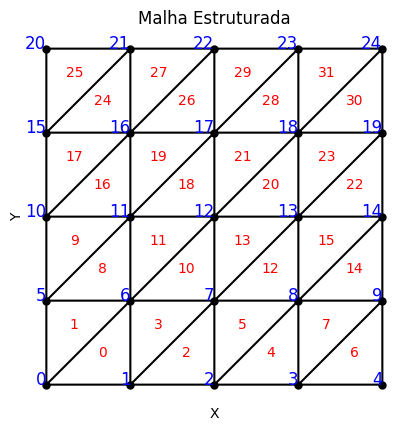

In [23]:
nx, ny = 5, 5
points, triangles = gerar_malha_estruturada(nx, ny)
plottar_malha(points, triangles, 'Malha Estruturada')

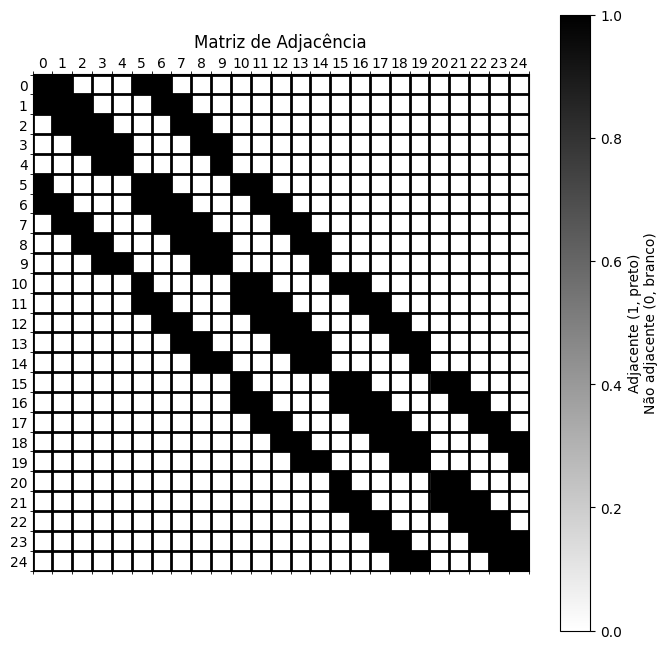

In [24]:
adj = gerar_matriz_adjacencia(points, triangles)
plottar_matriz_adjacencia(adj)

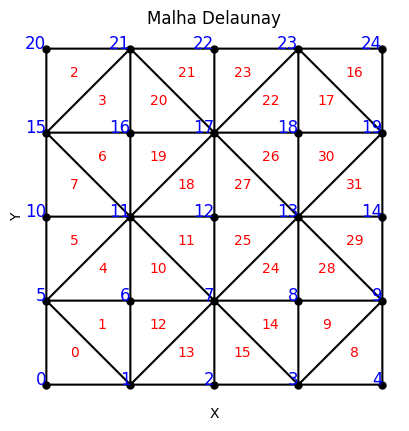

In [25]:
points_delaunay = gerar_pontos(nx, ny)
triangles_delaunay = Delaunay(points_delaunay).simplices
plottar_malha(points_delaunay, triangles_delaunay, 'Malha Delaunay')

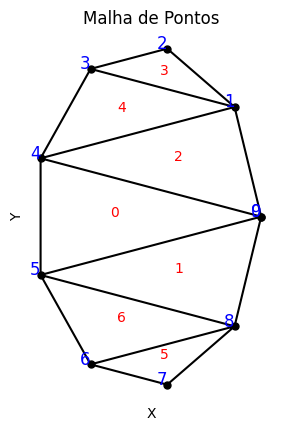

In [26]:
t = np.linspace(0, 2 * np.pi, 10)

x = 2 * np.cos(t)
y = 3 * np.sin(t)

points_funcao = np.vstack((x, y)).T
triangles_funcao = Delaunay(points_funcao).simplices

plottar_malha(points_funcao, triangles_funcao, 'Malha de Pontos')

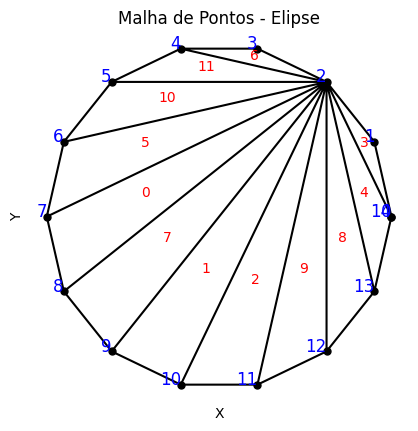

In [27]:
points_file = np.loadtxt('./data/ellipse.txt')
triangles_file = Delaunay(points_file).simplices
plottar_malha(points_file, triangles_file, 'Malha de Pontos - Elipse')

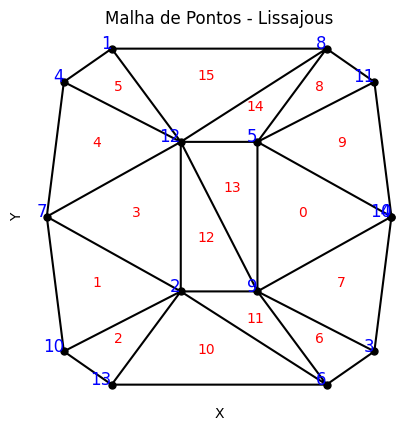

In [28]:
points_file = np.loadtxt('./data/lissajous.txt')
triangles_file = Delaunay(points_file).simplices
plottar_malha(points_file, triangles_file, 'Malha de Pontos - Lissajous')

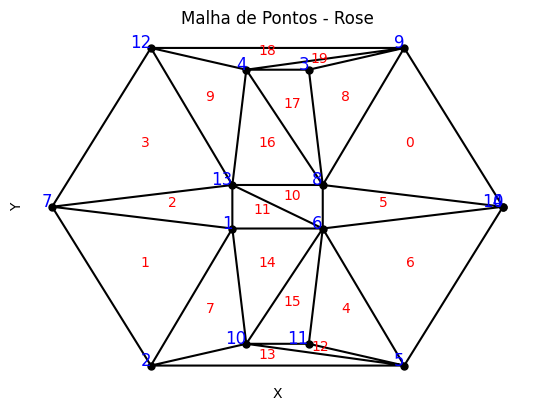

In [29]:
points_file = np.loadtxt('./data/rose.txt')
triangles_file = Delaunay(points_file).simplices
plottar_malha(points_file, triangles_file, 'Malha de Pontos - Rose')

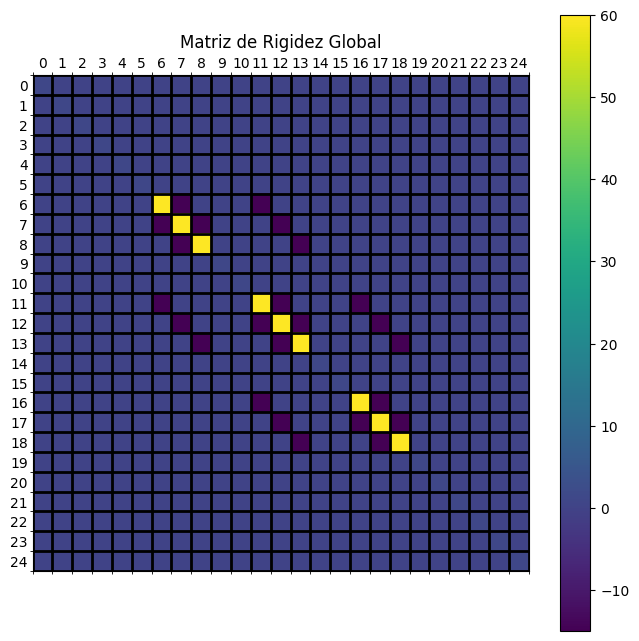

In [30]:
K_local, F_local = gerar_matriz_de_rigidez_local(points, triangles, k=15)
K, F = gerar_matriz_de_rigidez_global(points, triangles, K_local, F_local)
plottar_matriz_de_rigidez_global(K, F, points)

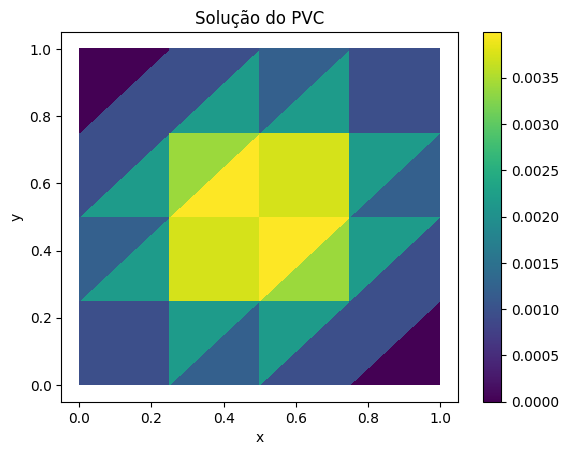

In [31]:
U = resolver_problema(K, F, points)
plottar_solucao(points, triangles, U)